In [13]:
%load_ext autoreload
%autoreload 2
import time 
from models import *
from utilsSimpleConv2D import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
BATCH_SIZE = 1
KERNEL_SIZES = [3, 5, 7, 9,11]
SEQ_LENGTH = [10, 20, 28, 32, 50, 60, 70]
IN_CHANNELS = 1
FILTERS = 1
STRIDE = 1
REPEAT = 200

In [39]:

TIMES = {
            'seq_length': [],
            'kernel_size': [],
            'variant': [],
            'med': [],
            'q1': [],
            'q2': []
        }

for kernel_size in KERNEL_SIZES:
    for seq_length in SEQ_LENGTH:
        # 1. Création des couches avec la taille de filtre variable
        classic_conv = tf.keras.layers.Conv2D(
            filters=FILTERS,
            kernel_size=(kernel_size,kernel_size),
            strides=STRIDE,
            padding="same",
            activation='relu'
        )

        # 2. Création de la convolution personnalisée   
        # Note: La convolution personnalisée est créée avec les mêmes paramètres que la classique 
        custom_conv = matrix_conv_2d(
            filters=FILTERS,
            kernel_size=kernel_size,
            strides=STRIDE,
            padding='SAME',
            activation="relu"
        )
        # Donnée aléatoire
        x = tf.random.normal((BATCH_SIZE, seq_length,seq_length, IN_CHANNELS))
        custom_conv.build((BATCH_SIZE, seq_length,seq_length, IN_CHANNELS))
          

        # Benchmark convolution personnalisée
        custom_times = []
        for _ in range(REPEAT):
            start = time.time()
            _ = custom_conv.conv_jit(x)
            end = time.time()
            custom_times.append(end - start)

        # Statistiques custom
        TIMES['seq_length'].append(seq_length)
        TIMES['kernel_size'].append(kernel_size)
        TIMES['variant'].append('custom_conv')
        TIMES['med'].append(np.median(custom_times))
        TIMES['q1'].append(np.quantile(custom_times, 0.25))
        TIMES['q2'].append(np.quantile(custom_times, 0.85))

        # Benchmark convolution classique
        classic_times = []
        for _ in range(REPEAT):
            start = time.time()
            _ = classic_conv(x)
            end = time.time()
            classic_times.append(end - start)

        # Statistiques classiques
        TIMES['seq_length'].append(seq_length)
        TIMES['kernel_size'].append(kernel_size)
        TIMES['variant'].append('classic_conv')
        TIMES['med'].append(np.median(classic_times))
        TIMES['q1'].append(np.quantile(classic_times, 0.25))
        TIMES['q2'].append(np.quantile(classic_times, 0.85))

# Résultats dans un DataFrame
data = pd.DataFrame(TIMES)
data.to_csv('benchmarks_matrix_conv_2d_cpu.csv', index=False)
# data.set_index('kernel_size', inplace=True)
# data = data.pivot_table(index='kernel_size', columns='variant', values=['med', 'q1', 'q2'])


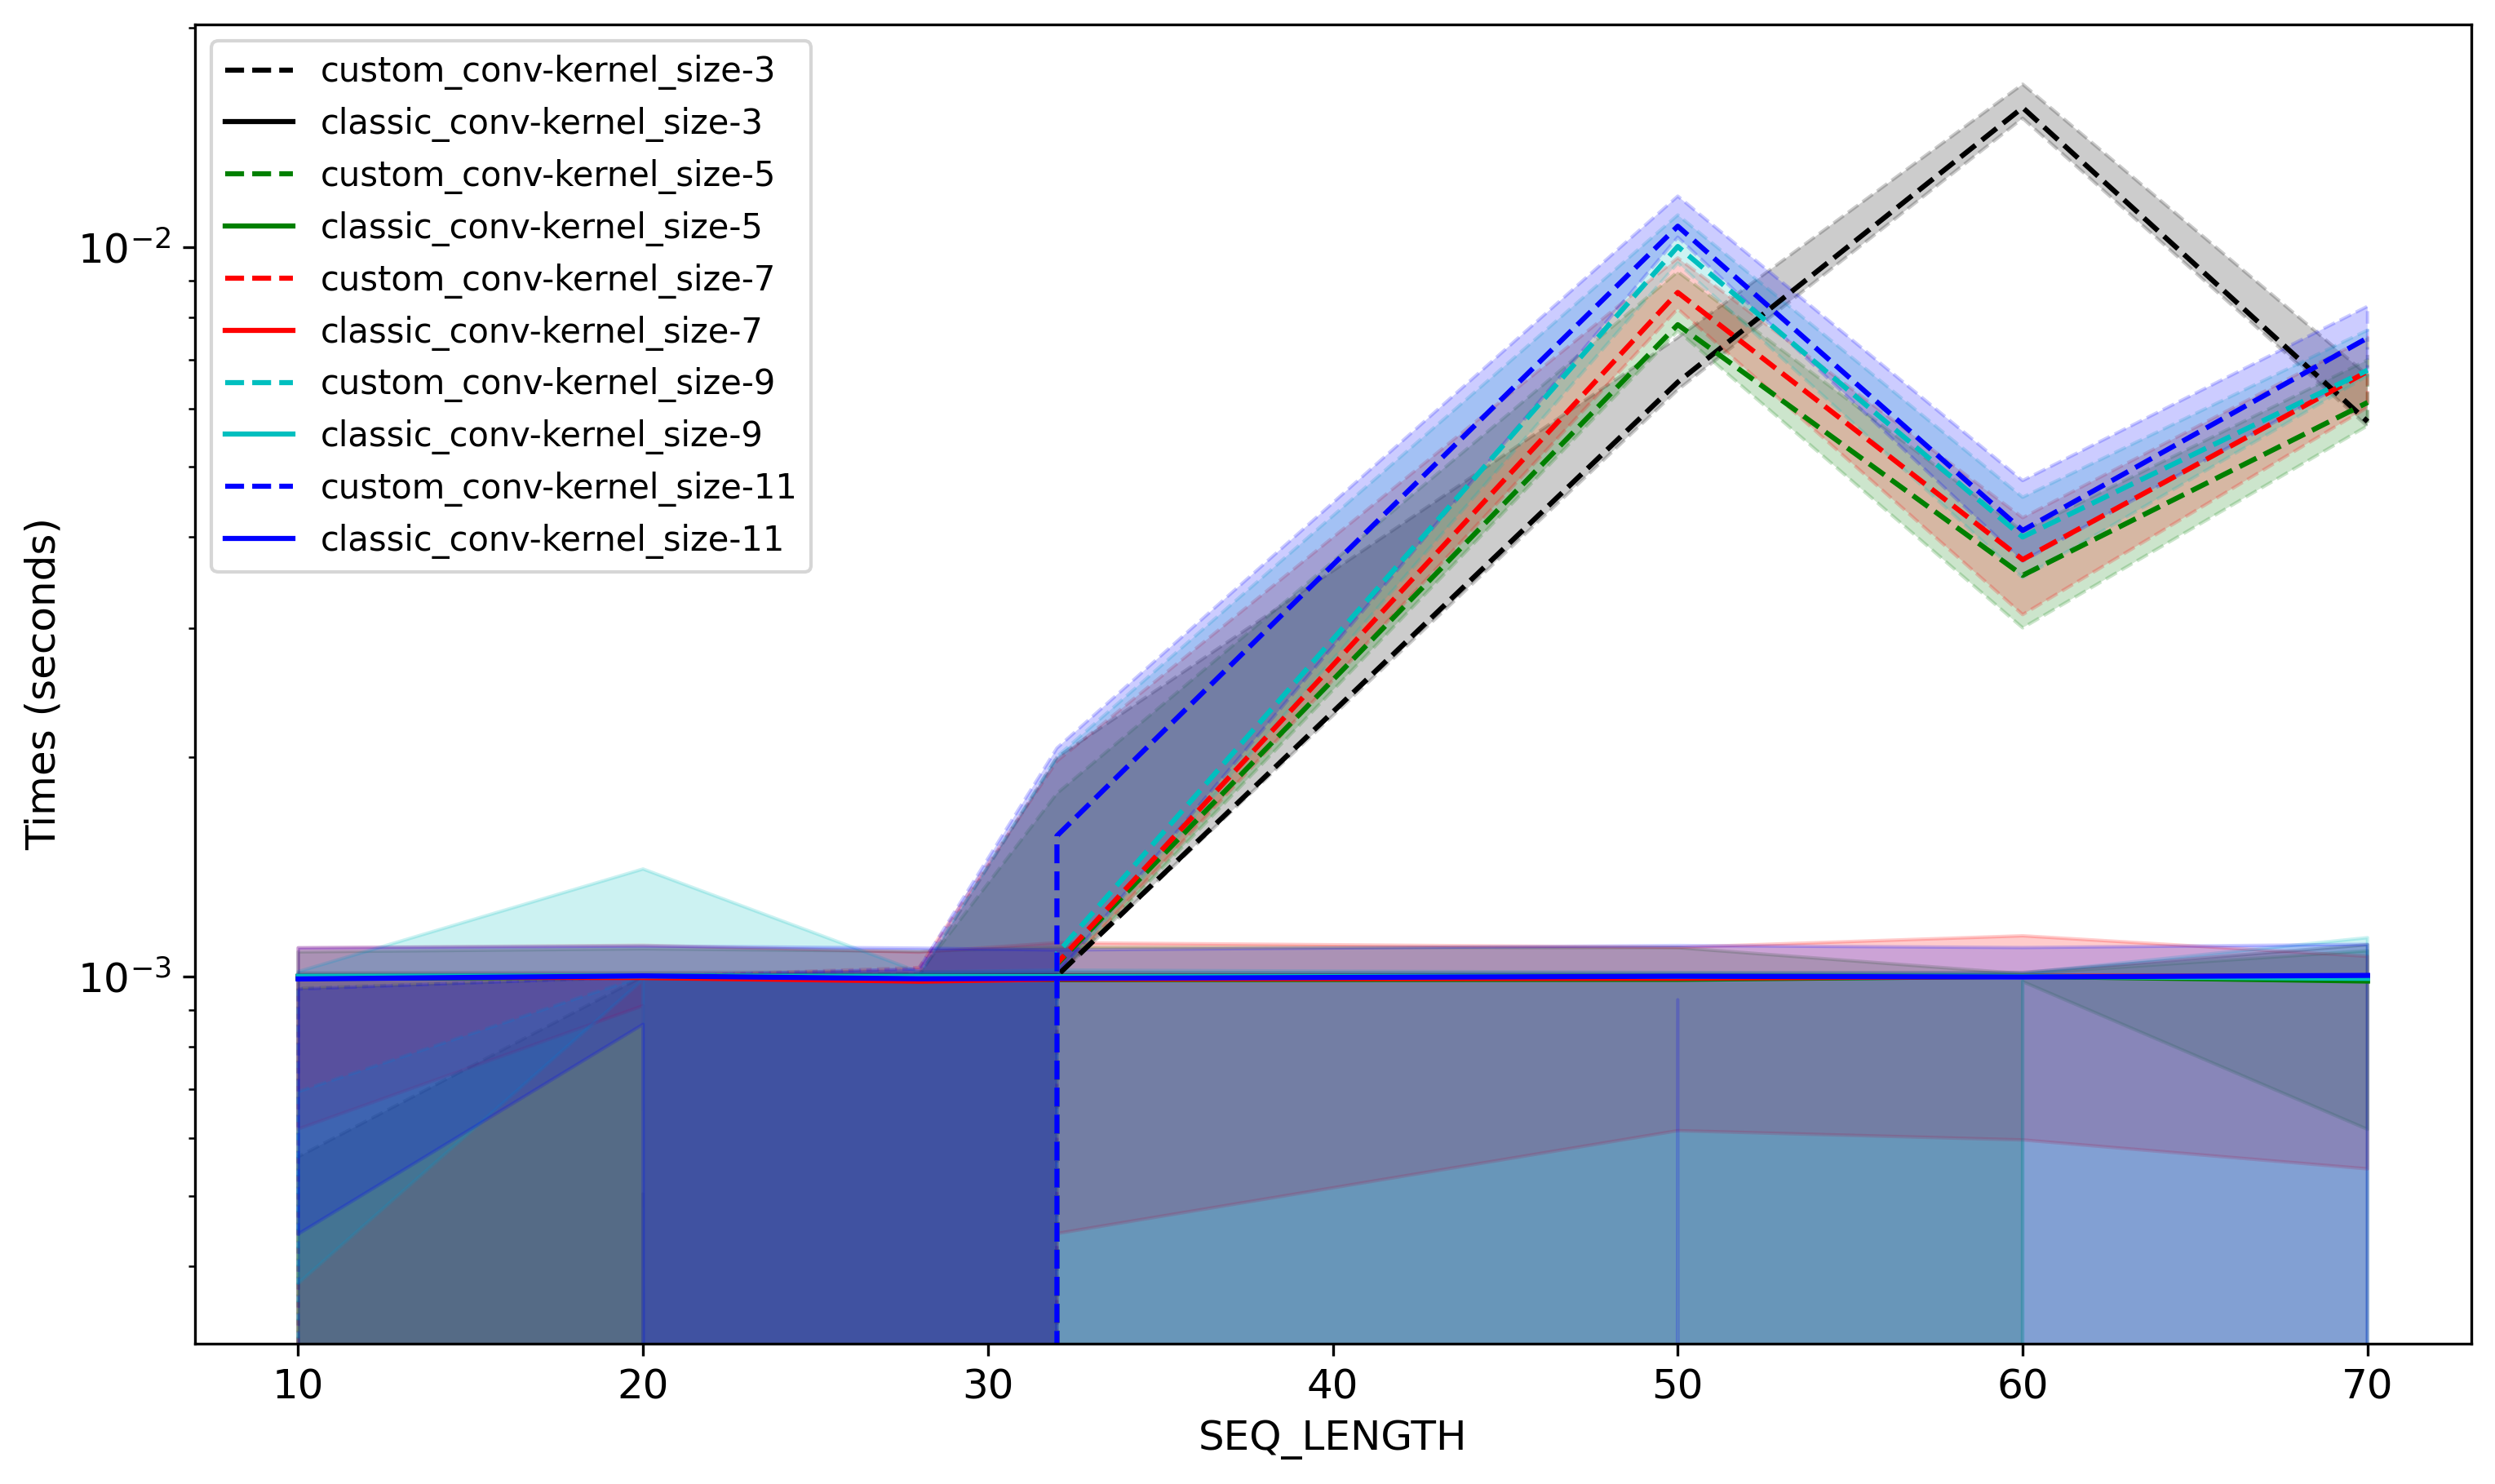

In [40]:
plot_benchmarks(data,loc='upper left',save_fig=True,filename='benchmarks_conv2d_cpu.pdf')